## Examine cost measure heuristic induced by naive embedding of the 8-puzzle state space on the sphere $\mathbb{S}^8$

Some relevant plots to pique the interest

induced heuristic with mean centering | induced heuristic with goal centering 
- | -
![example of induced heuristic with mean centering](plt1.png "plot 1")|![example of induced heuristic with goal centering](plt2.png "plot 2")

In [1]:
import numpy as np

# helper function
def euc_dist(v1,v2):
    
    assert len(v1) == len(v2)
    
    square_diffs = [(v1[i] - v2[i])**2 for i in range(len(v1))]
    return np.sqrt(sum(square_diffs))
    
def mink_dist(v1,v2):
    
    assert len(v1) == len(v2)
    
    abs_diffs = [np.abs(v1[i] - v2[i]) for i in range(len(v1))]
    return sum(abs_diffs)

$s$ is a generic initial state from $\Theta$ (corresponding to a specific configuration as described in my write up) embedded into $\mathbb{R}^{3 \times 3} \cong \mathbb{R}^9$. 

Similarly, $g$ is the embedded goal state.

In [2]:
s = np.array([0,4,2,1,3,5,6,8,7])
g = np.array(list(range(9))) # goal state

print('Euclidean distance:', euc_dist(s,g))
print('Minkovsky distance:', mink_dist(s,g))

Euclidean distance: 4.0
Minkovsky distance: 8


### Define the sphere map $\phi^{-1}$ which embeds Euclidean space $\phi^{-1}:\mathbb{R}^n \hookrightarrow \mathbb{S}^n$ into the $n$-sphere via stereographic projection. Define the induced metric $h_g(s)$ where $\psi : \Theta \to \mathbb {R}^n$ is the embedding of the configuration space
$$
h_g(s) := \frac{1}{\pi} \| \phi^{-1} \circ \psi (s) - \phi^{-1} \circ \psi (g) \|_{\text{geodesic}}
$$

In [3]:
def sphere_map(x):
    
    scale = 1 / (1 + euc_dist( [0]*len(x), x) ** 2)
    
    temp_y = [2*t for t in x]
    temp_y += [1 - euc_dist( [0]*len(x), x) ** 2]
    y = np.array([scale * t for t in temp_y ])
    
    return y

def h(s, target=g): # induced metric on the sphere
    
    h = np.arccos( np.dot( sphere_map(s), sphere_map(target) ) ) / np.pi
    return h


In [4]:
print('configuration s embedded on the 9-sphere:', "\n", sphere_map(s), '\n'*2+'goal g embedded on the 9 sphere:', '\n', sphere_map(g), '\n')

print('induced heuristic cost of s:', h(s))

configuration s embedded on the 9-sphere: 
 [ 0.          0.03902439  0.0195122   0.0097561   0.02926829  0.04878049
  0.05853659  0.07804878  0.06829268 -0.9902439 ] 

goal g embedded on the 9 sphere: 
 [ 0.          0.0097561   0.0195122   0.02926829  0.03902439  0.04878049
  0.05853659  0.06829268  0.07804878 -0.9902439 ] 

induced heuristic cost of s: 0.0124226375717


### Evolving states towards goal
I think it would be interesting to see how this cost evolves compared with euclidean distance, if we were to evolve the initial state to the goal state along a smooth (linearly interpolated) trajectory.

In [5]:
from scipy.interpolate import interp1d

def evolv_cost(s,g, scale=100):
    """
    scale = granularity of the interpolation (number of generated data points)
    note: fix to have this return the t dataset automatically
    """
    
    linfit = interp1d([0,1], np.vstack([s,g]), axis=0)
    alpha = scale#200
    t = np.array(list(range(alpha+1)))/alpha
    sequence = linfit(t)
    g = np.reshape(g, newshape=(9,1))
    cost_sphere = np.array([ h( sequence[i:i+1][0], target = g ) for i in range(alpha+1) ])
    cost_euclid = np.array([ euc_dist( sequence[i:i+1][0], g ) for i in range(alpha+1) ])

    return cost_sphere, cost_euclid


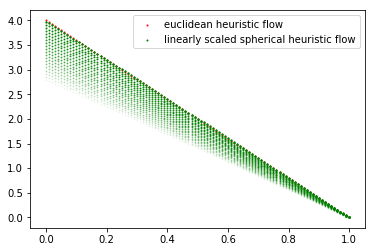

In [6]:
import matplotlib.pyplot as plt

alpha = 100
t = np.array(list(range(alpha+1)))/alpha

cost_sphere, cost_euclid = evolv_cost(s,g, scale=alpha)
plt.scatter(t, cost_euclid, s=1, color='red')

scaling_coeff = 320 
# empirically determined in this case. 
# used to compare cost based on euclidean heuristic vs spherical heuristic

plt.scatter(t, scaling_coeff*cost_sphere, s=1, color='green')

labels = ('euclidean heuristic flow','linearly scaled spherical heuristic flow')
plt.legend(labels,loc ='best')

for i in range(20):
    plt.scatter(t, (scaling_coeff - 5*i)*cost_sphere, s=1, color='green', alpha=1-i/20)
    
# plt.scatter(t, cost_sphere, s=1, color='blue')
plt.show()

The gradient green curves indicate the spherical heuristic flow at different scalings. We can examine the difference between euclidean and spherical heuristics: 


In [7]:
temp = []

for k in range(500):
    temp.append(euc_dist(cost_euclid, k*cost_sphere))

minimizing_scaling = temp.index(min(temp))

print('a few examples:' + '\n'+ 'for s = '+ str(s) +', scaling = ' + str(minimizing_scaling) + ' minimizes error to ' + str(min(temp)[0]))
print('for s = [8 7 5 6 3 4 1 0 2], scaling = 292 minimizes error to 4.61657357')

a few examples:
for s = [0 4 2 1 3 5 6 8 7], scaling = 320 minimizes error to 0.0731690682409
for s = [8 7 5 6 3 4 1 0 2], scaling = 292 minimizes error to 4.61657357


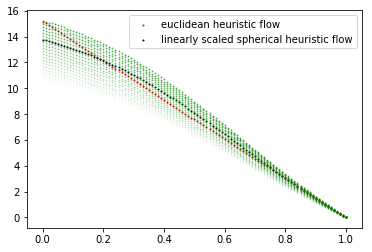

In [8]:
# comparison

s = [8, 7, 5, 6, 3, 4, 1, 0, 2]

alpha = 100
t = np.array(list(range(alpha+1)))/alpha

cost_sphere, cost_euclid = evolv_cost(s,g, scale=alpha)
plt.scatter(t, cost_euclid, s=1, color='red')

scaling_coeff = 292 
plt.scatter(t, scaling_coeff*cost_sphere, s=1, color='black')

labels = ('euclidean heuristic flow','linearly scaled spherical heuristic flow')
plt.legend(labels,loc ='best')

scaling_coeff = 323 # again empirically determined to give range in graph
for i in range(20):
    plt.scatter(t, (scaling_coeff - 5*i)*cost_sphere, s=1, color='green', alpha=.5*(1-i/20))
    
plt.show()

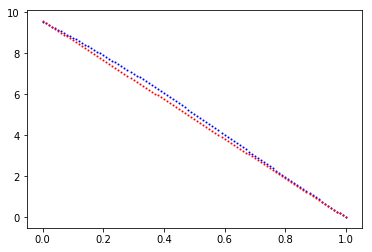

In [9]:
# another quick example

s_prime = np.array([1,5,6,0,4,7,3,8,2])
h(s_prime)
cost_sphere, cost_euclid = evolv_cost(s_prime,g)

plt.scatter(t, 320*np.array(cost_sphere), s=1, color='blue')
plt.scatter(t, np.array(cost_euclid), s=1, color='red')
plt.show()

### Idea - randomly sample from starting locations and look at the distribution and evolution of spherical cost

We randomly sample $s$ from $\Theta$ and examine the resulting evolution of spherical cost.

In [10]:
simulation_size = 500

num_examples = 20

# dist_scale_coef = 320

scaling_factors = []
diffs = []

selected_indices=np.random.choice(a = range(simulation_size), size = num_examples, replace=False)

selected_data = []
unusual_examples = [] # rewrite how these are selected

for k in range(simulation_size):
    
    initial_configuration = np.random.choice( a=list(range(9)),size=(9,),replace=False )
    
    cost_sphere, cost_euclid = evolv_cost(initial_configuration,g)

    eps = 0.00001 # avoid divide by 0 numerical issues as both euclid and spherical cost -> 0 as 'time' -> 1

    _scale = np.mean( [ (cost_euclid[i] + eps) / (cost_sphere[i] + eps) for i in range(10, len(cost_sphere) - 10)] ) # 10 bumps away from edge cases where both go to 0
    scaling_factors.append(_scale) # measures linearity of relationship between spherical and euclidean cost evolution
    
#     scaled_cost_sphere = dist_scale_coef * cost_sphere
    scaled_cost_sphere = _scale * cost_sphere
    
    if (_scale > 315) | (_scale < 285): unusual_examples.append(initial_configuration) # interesting so save
    
    discrepancy = euc_dist(scaled_cost_sphere , cost_euclid)
    diffs.append(discrepancy)
    
    if k in selected_indices:
        selected_data.append([ k, [ initial_configuration, cost_sphere, cost_euclid ] ])

## printing out basic info about diffs
print('discrepancy between euclidean and spherical:')
upper = np.mean(diffs) + 2 * np.std(diffs)
lower = np.mean(diffs) - 2 * np.std(diffs)
print('lower:', lower, 'upper:', upper, 'mean:', np.mean(diffs))

print('\n')

## printing out basic info about scale / linearity
print('statistics about linear scaling:')
upper = np.mean(scaling_factors) + 2 * np.std(scaling_factors)
lower = np.mean(scaling_factors) - 2 * np.std(scaling_factors)
print('lower:', lower, 'upper:', upper, 'mean:', np.mean(scaling_factors))

print('\n')

print("number of relatively 'unusual' examples:", len(unusual_examples))

discrepancy between euclidean and spherical:
lower: 0.0510351886261 upper: 3.96345944156 mean: 2.00724731509


statistics about linear scaling:
lower: 288.971554084 upper: 315.499320499 mean: 302.235437291


number of relatively 'unusual' examples: 11


We can examine a few randomly selected examples from the simulation. Here sphericial cost is scaled by the average scaling constant over the heuristic evolution *on each individual example's scale* (so scaling coefficient(s) vary over examples)

52 indexed at : 0


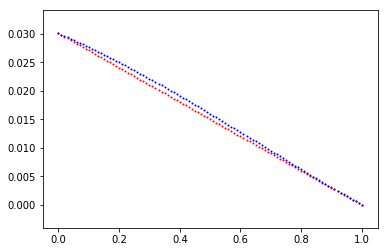

107 indexed at : 1


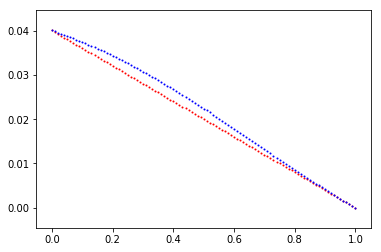

In [11]:
budget = 2
# this is the number of plots you're willing to look at
# should put these in a plot matrix at some point

for item in selected_data[0:budget]:
    
    _id = item[0]
    initial_state = item[1][0]

    cost_sphere = item[1][1]
    cost_euclid = item[1][2]

    print(_id , 'indexed at :', selected_data.index(item))
    
    
    # examine just sphere cost
    num_points = len(cost_sphere)
    lin_comparison = np.linspace(cost_sphere[0], cost_sphere[num_points-1], num_points)
    
    alpha = 100 # default scale used in evolv_cost for previous simulation
    t = np.array(list(range(alpha+1)))/alpha
    
    plt.scatter(t, lin_comparison, s=1, color='red')
    plt.scatter(t, cost_sphere, s=1, color='blue')

    # examine sphere cost vs euclidean dist
#     plt.scatter(t, 320*np.array(cost_sphere), s=1, color='blue')
#     plt.scatter(t, np.array(cost_euclid), s=1, color='red')
    plt.show()

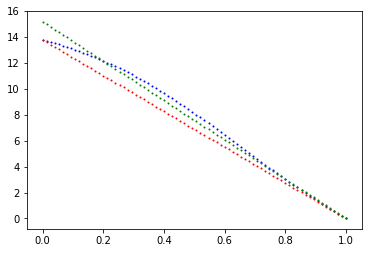

In [12]:
#interesting configuration

another_config = unusual_examples[0] 
another_config = [0, 1, 4, 5, 3, 2, 7, 6, 8] # saved from a previous sample

interesting_config = selected_data[4][1][0] # from looking at plots above, selecting an interesting one
interesting_config = [8, 7, 5, 6, 3, 4, 1, 0, 2] # saved from previous sample

# plot from above config

s = interesting_config

alpha = 75
cost_sphere, cost_euclid = evolv_cost(s,g, scale=alpha)

# scaling
temp = []
for k in range(500):
    temp.append(euc_dist(cost_euclid, k*cost_sphere))
min_scaling = temp.index(min(temp))
scaled_cost_sphere = min_scaling*cost_sphere

t = np.array(list(range(alpha+1)))/alpha

plt.scatter(t, scaled_cost_sphere, s=1, color='blue')
lin_comparison = np.linspace(scaled_cost_sphere[0], scaled_cost_sphere[alpha], alpha+1)
plt.scatter(t, lin_comparison, s=1, color='red')

plt.scatter(t, cost_euclid, s=1, color='green')

plt.show()

## Effect of Centering 

i.e., examine the importance of the embedding of the state space $\Theta$ into the sphere $\mathbb{S}^9$ upon determining heuristic evolution.

In [13]:
def center(x, _type=1): # assume a state from 8-puzzle
    
    """
    centers based on x - µ (type I)
    or based on x - g (type II) (so that g is sent to origin and hence to a pole in sphere embedding)
    """
    
#     assert type(x) == numpy.ndarray
    
    ## this will give same results
    #_max = 8
    #_min = 0
    #center = (_max - _min) / 2 # = 4 for s in Theta
    ##
    
    if _type==1: center = np.mean(x) # turns out this = 4 for s in Theta
    if _type==2: center = g # g = global variable, goal state embedded into R^9

    
    return x - center

print('\n' + "' * "*3 + 'Type I centering' + " * '"*3 + '\n' )
print('centered s:', center(s))
print('centered g:',center(g))
# print('centered configuration:',center(interesting_config))
print('\n' + "' * "*3 + 'Type II centering' + " * '"*3 + '\n' )
print('centered s:', center(s, _type=2))
print('centered g:',center(g, _type=2))


' * ' * ' * Type I centering * ' * ' * '

centered s: [ 4.  3.  1.  2. -1.  0. -3. -4. -2.]
centered g: [-4. -3. -2. -1.  0.  1.  2.  3.  4.]

' * ' * ' * Type II centering * ' * ' * '

centered s: [ 8  6  3  3 -1 -1 -5 -7 -6]
centered g: [0 0 0 0 0 0 0 0 0]


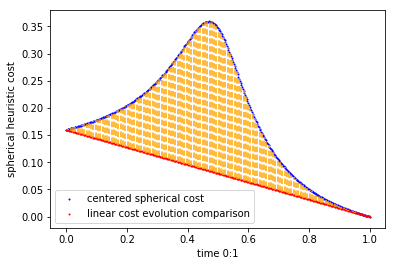

In [14]:
# quick examples

s = np.array([0, 4, 2, 1, 3, 5, 6, 8, 7])
s = interesting_config
centered_s = center(s)
centered_g = center(g)

alpha = 400

cost, _ = evolv_cost(s,g, scale=alpha)
centered_cost, _ = evolv_cost(centered_s,centered_g, scale=alpha)

# num_points = len(cost_sphere) # just use alpha

t = np.array(list(range(alpha+1)))/alpha

plt.scatter(t, centered_cost, s=1, color='blue')
lin_comparison = np.linspace(centered_cost[0], centered_cost[alpha], alpha+1)
plt.scatter(t, lin_comparison, s=1, color='red')

labels = ('centered spherical cost','linear cost evolution comparison')
plt.legend(labels,loc ='best')


# plt.scatter(t, np.array(cost), s=1, color='blue')


# # fill in plot difference HORIZONTAL - only visible if nonlinear
# fill_increment = 2
# denseness = 3 # closer to 1 is denser
# for i in range(1, int(alpha/denseness) - 1):
    
#     _index = denseness*i
#     x = t[_index + fill_increment] # makes horiz lines start within line boundaries
#     y = lin_comparison[_index]
    
#     # get x where horizontal line passes centered_cost:
#     ##
#     k = _index
#     while centered_cost[k] > y:
#         k+=fill_increment
#     ##
#     new_x = t[k-fill_increment] 
#     plt.plot( [x,new_x],[y,y], linestyle='dashed', color='orange' )



# fill in plot difference VERTICAL - only visible if nonlinear
denseness = 3 # closer to 1 is denser
for i in range(1, int(alpha/denseness) - 1):
    
    _index = denseness*i
    x = t[_index] 
    y = lin_comparison[_index]
    new_y = centered_cost[_index]
    
    plt.plot( [x,x],[y,new_y], linestyle='dashed', color='orange' )


plt.xlabel("time 0:1")
plt.ylabel("spherical heuristic cost")

# save to display later
plt.savefig('plt1.png', dpi=500)

plt.show()
plt.close()  

Let's repeat the above example but with 'goal-centric' centering
### Goal Centering

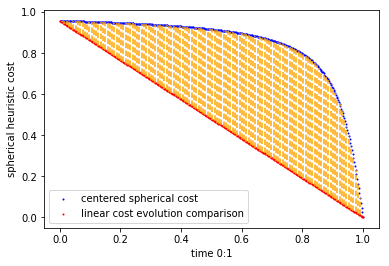

In [15]:
# quick example

s = np.array([0, 4, 2, 1, 3, 5, 6, 8, 7])
s = interesting_config
centered_s = center(s, _type=2)
centered_g = center(g, _type=2)

alpha = 400

cost, _ = evolv_cost(s,g, scale=alpha)
centered_cost, _ = evolv_cost(centered_s,centered_g, scale=alpha)

# num_points = len(cost_sphere) # just use alpha

t = np.array(list(range(alpha+1)))/alpha

plt.scatter(t, centered_cost, s=1, color='blue')
lin_comparison = np.linspace(centered_cost[0], centered_cost[alpha], alpha+1)
plt.scatter(t, lin_comparison, s=1, color='red')


labels = ('centered spherical cost','linear cost evolution comparison')
plt.legend(labels,loc ='best')


# fill in plot difference VERTICAL - only visible if nonlinear
denseness = 3 # closer to 1 is denser
for i in range(1, int(alpha/denseness)):
    
    _index = denseness*i
    x = t[_index] 
    y = lin_comparison[_index]
    new_y = centered_cost[_index]
    
    plt.plot( [x,x],[y,new_y], linestyle='dashed', color='orange' )


plt.xlabel("time 0:1")
plt.ylabel("spherical heuristic cost")

# save to display later
plt.savefig('plt2.png', dpi=500)

plt.show()
plt.close()  